In [117]:
#ORIE 5741 Project Code

In [106]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
# Data and EDA
df = pd.read_csv("aviation_accident.csv")
df.head()

/var/folders/j2/kn24rgbs61zdgt6q877h9x0c0000gn/T/ipykernel_85552/1885492614.py:2: DtypeWarning: Columns (0,13,22,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("aviation_accident.csv")


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,...,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Year,Month.Abbr,Day.Name.Abbr,Weekend,City,State
0,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,BLACKBURN AG STRIP,Non-Fatal,Substantial,...,VMC,Takeoff,Probable Cause,01-01-1982,1982.0,Jan,Fri,False,PULLMAN,WA
1,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,N58,HANOVER,Non-Fatal,Substantial,...,IMC,Landing,Probable Cause,01-01-1982,1982.0,Jan,Fri,False,EAST HANOVER,NJ
2,20020909X01560,Accident,MIA82DA029,1982-01-01,"JACKSONVILLE, FL",United States,JAX,JACKSONVILLE INTL,Non-Fatal,Substantial,...,IMC,Cruise,Probable Cause,01-01-1982,1982.0,Jan,Fri,False,JACKSONVILLE,FL
3,20020909X01559,Accident,FTW82DA034,1982-01-01,"HOBBS, NM",United States,NaN,NaN,Non-Fatal,Substantial,...,VMC,Approach,Probable Cause,01-01-1982,1982.0,Jan,Fri,False,HOBBS,NM
4,20020909X01558,Accident,ATL82DKJ10,1982-01-01,"TUSKEGEE, AL",United States,NaN,TUSKEGEE,Non-Fatal,Substantial,...,VMC,Landing,Probable Cause,01-01-1982,1982.0,Jan,Fri,False,TUSKEGEE,AL


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68565 entries, 0 to 68564
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                67128 non-null  object 
 1   Investigation.Type      68565 non-null  object 
 2   Accident.Number         68565 non-null  object 
 3   Event.Date              68565 non-null  object 
 4   Location                68561 non-null  object 
 5   Country                 68565 non-null  object 
 6   Airport.Code            40695 non-null  object 
 7   Airport.Name            43033 non-null  object 
 8   Injury.Severity         67076 non-null  object 
 9   Aircraft.damage         66209 non-null  object 
 10  Registration.Number     67127 non-null  object 
 11  Make                    67119 non-null  object 
 12  Model                   67105 non-null  object 
 13  Amateur.Built           67127 non-null  object 
 14  Number.of.Engines       65501 non-null

In [5]:
df.isna().sum()

Event.Id                   1437
Investigation.Type            0
Accident.Number               0
Event.Date                    0
Location                      4
Country                       0
Airport.Code              27870
Airport.Name              25532
Injury.Severity            1489
Aircraft.damage            2356
Registration.Number        1438
Make                       1446
Model                      1460
Amateur.Built              1438
Number.of.Engines          3064
Engine.Type                4000
Purpose.of.flight          2556
Total.Fatal.Injuries       1437
Total.Serious.Injuries     1437
Total.Minor.Injuries       1437
Total.Uninjured            1437
Weather.Condition          1964
Broad.phase.of.flight     22030
Report.Status              4002
Publication.Date          15091
Year                       2874
Month.Abbr                 2874
Day.Name.Abbr              2874
Weekend                    2874
City                       2882
State                      2930
dtype: i

In [6]:
# Key Observations

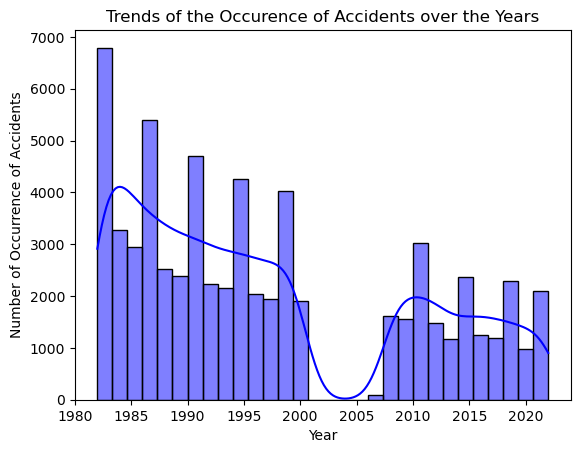

<Figure size 600x600 with 0 Axes>

In [7]:
# What are the trends of the occurrence of aviation accidents over the years
df_year_dropped = df['Year'].dropna()

sns.histplot(df_year_dropped, bins=30, kde=True, color='blue')

plt.xlabel('Year')  # X-axis label
plt.ylabel('Number of Occurrence of Accidents')      # Y-axis label
plt.title('Trends of the Occurence of Accidents over the Years')  # Title of the histogram
plt.figure(figsize=(6, 6))

plt.show()


There's a pronounced peak in the number of accidents in the early 1980s. This suggests that during this period, accidents were more frequent than in later years. Following the initial peak, there's a notable decline in the number of accidents that continues until around the 2020. And also notice that with every 2 or 3 years, there is peak of the number of accidents.

In [8]:
# What are the average survival rates in each year?

In [9]:
# Check the columns related with the number of poeple invovled in each accident 
df_survival = df[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']]
df_survival.head()

,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,2.0
2,0.0,0.0,3.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


In [10]:
df_survival.sum()

Total.Fatal.Injuries       24750.0
Total.Serious.Injuries     15676.0
Total.Minor.Injuries       19318.0
Total.Uninjured           164046.0
dtype: float64

In [11]:
# Calculate total people involved in each accident
df['Total_People'] = df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] + df['Total.Minor.Injuries'] + df['Total.Uninjured']

# Calculate the number of survivors (assuming survival means no fatal injuries)
df['Survivors'] = df['Total.Serious.Injuries'] + df['Total.Minor.Injuries'] + df['Total.Uninjured']

# Calculate survival rate for each accident
df['Survival.Rate'] = df['Survivors'] / df['Total_People']

# Calculate average survival rate by year
average_survival_by_year = df.groupby('Year')['Survival.Rate'].mean()


In [12]:
average_survival_by_year = pd.DataFrame(average_survival_by_year)
average_survival_by_year = average_survival_by_year.reset_index()
average_survival_by_year.columns = ['Year', 'Survival Rate']
average_survival_by_year.head()

,Year,Survival Rate
0,1982.0,0.834367
1,1983.0,0.826339
2,1984.0,0.827713
3,1985.0,0.833189
4,1986.0,0.834124


In [13]:
average_survival_by_year['Year'] = average_survival_by_year['Year'].round().astype(int)
average_survival_by_year['Survival Rate'] = average_survival_by_year['Survival Rate'].round(3)
average_survival_by_year.head()

,Year,Survival Rate
0,1982,0.834
1,1983,0.826
2,1984,0.828
3,1985,0.833
4,1986,0.834


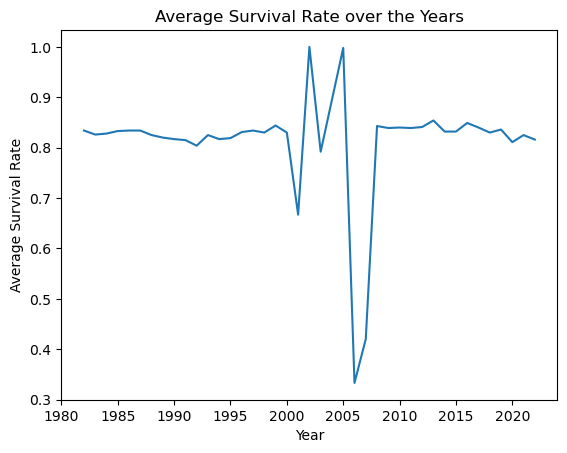

In [14]:
plt.plot(average_survival_by_year['Year'], average_survival_by_year['Survival Rate'])

plt.xlabel('Year')  # X-axis label
plt.ylabel('Average Survival Rate')      # Y-axis label
plt.title('Average Survival Rate over the Years')  # Title of the histogram

plt.show()

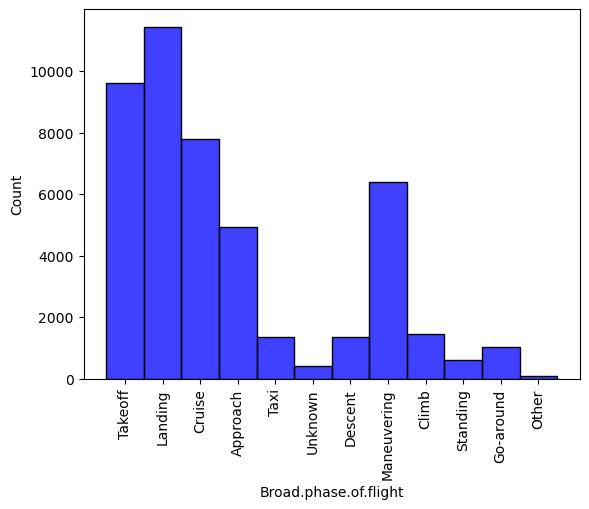

<Figure size 600x600 with 0 Axes>

In [15]:
# Which phase of flight do most accidents occur?
plt.xticks(rotation=90)
sns.histplot(df["Broad.phase.of.flight"], bins=12, kde=False, color='blue')

plt.figure(figsize=(6, 6))
plt.show()

# Most accident tended to happen in the landing phase of flight.

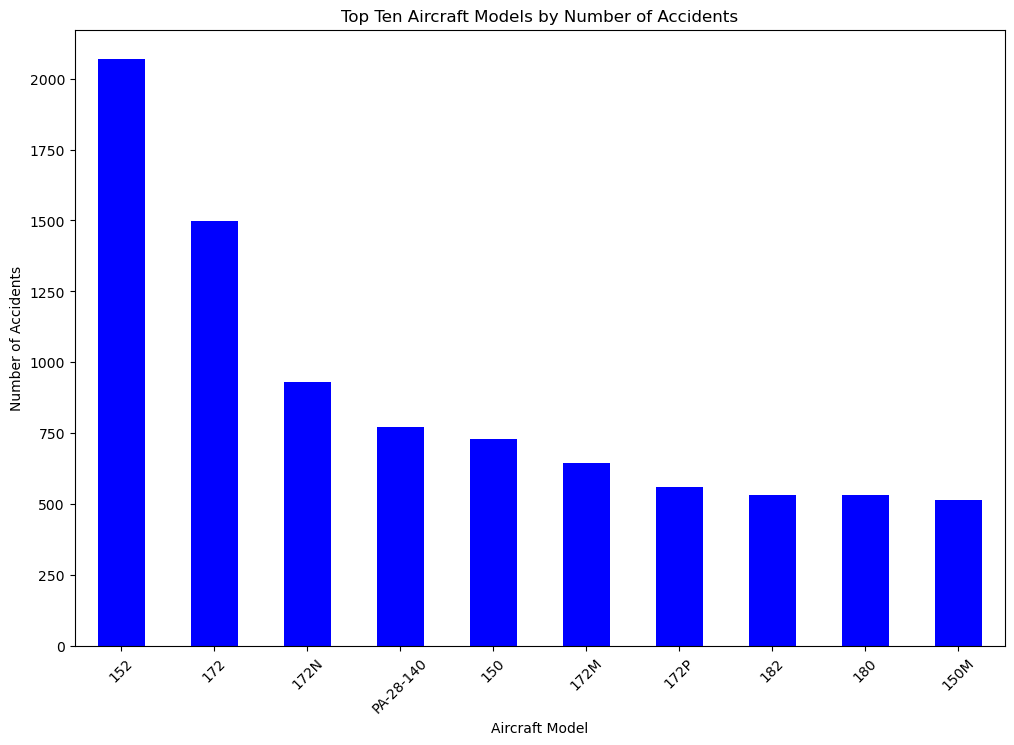

<Figure size 640x480 with 0 Axes>

In [16]:
# Which model do most accidents occur?
# Calculate the count of incidents for each model and get the top ten models with the largest number of incidents
top_models_by_incidents = df['Model'].value_counts().head(10)

# Plotting the top ten models by number of incidents
plt.figure(figsize=(12, 8))
top_models_by_incidents.plot(kind='bar', color='blue')
plt.title('Top Ten Aircraft Models by Number of Accidents')
plt.xlabel('Aircraft Model')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

plt.savefig('Top_Ten_Aircraft_Models.png', format='png', dpi=300)

In [17]:
# Feature Engineering 

In [18]:
# Data Preprocessing – Dropping column with no predictive power
df_basic = df
df_basic[['Event.Id', 'Accident.Number', 'Registration.Number']].head()

,Event.Id,Accident.Number,Registration.Number
0,20020909X01562,SEA82DA022,N2482N
1,20020909X01561,NYC82DA015,N7967Q
2,20020909X01560,MIA82DA029,N3906K
3,20020909X01559,FTW82DA034,N44832
4,20020909X01558,ATL82DKJ10,N4275S


In [19]:
# The following columns are unique identifiers of the accident and provide no predictive power. 
# We will drop them. 
df_basic = df_basic.drop(columns=['Event.Id', 'Accident.Number', 'Registration.Number'])

In [20]:
df_basic[['Investigation.Type', 'Report.Status']].head()
# The following columns are administrative details, which are not predictive of accident outcomes.
# We will drop them

,Investigation.Type,Report.Status
0,Accident,Probable Cause
1,Accident,Probable Cause
2,Accident,Probable Cause
3,Accident,Probable Cause
4,Accident,Probable Cause


In [21]:
df_basic = df_basic.drop(columns=['Investigation.Type', 'Report.Status'])

In [22]:
df_basic[['Event.Date', 'Publication.Date']].head()
# The following columns are days that th event happened, which is not helpful. 
# We will drop them

,Event.Date,Publication.Date
0,1982-01-01,01-01-1982
1,1982-01-01,01-01-1982
2,1982-01-01,01-01-1982
3,1982-01-01,01-01-1982
4,1982-01-01,01-01-1982


In [23]:
# We will first frop the Publicaiton.Data columns. At this moment we still
# need the Event.Data column to help us fill in the missing data in the 
# columns "Year", "Month", and "Day.Name.Abbr"
df_basic = df_basic.drop(columns=['Publication.Date'])

In [24]:
df_basic[['Location', 'Country', 'City', 'State']].isnull().sum()
# The following columns are geographic data that might have some insights. But without further information, 
# it is hard to utilize these data. We will drop them.

Location       4
Country        0
City        2882
State       2930
dtype: int64

In [25]:
df_basic['Location'].value_counts()

Location
ANCHORAGE, AK        332
Sat                  272
Fri                  227
Sun                  208
Thu                  207
                    ... 
CINNIBAR, AK           1
CRESCENT LAKE, AK      1
WILMONT, AR            1
FT. PAYNE, AL          1
Auburn Hills, MI       1
Name: count, Length: 20964, dtype: int64

In [26]:
df_basic['State_Location'] = df_basic['Location'].str.split(', ').str[1]
df_basic['State_Location'] = df_basic['State_Location'].fillna(df_basic['State'])
# df_basic['State_Locaiton'] = df_basic['State_Locaiton'].fillna('Unknown')

In [27]:
df_basic['State_Location'].isnull().sum()

1493

In [28]:
df_basic = df_basic.drop(columns=['Location', 'Country', 'City', 'State'])

In [29]:
# Since we construct the new column survival_rate, survivors, and total_people, we will drop
# 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured'.
# We will also drop survivors, and total_people becuase we use them to generate survival_rate.
df_basic = df_basic.drop(columns=['Total.Fatal.Injuries', 'Total.Serious.Injuries', 
                                 'Total.Minor.Injuries', 'Total.Uninjured', 'Total_People', 'Survivors'])
df_basic.shape

(68565, 19)

In [30]:
df_basic.columns

Index(['Event.Date', 'Airport.Code', 'Airport.Name', 'Injury.Severity',
       'Aircraft.damage', 'Make', 'Model', 'Amateur.Built',
       'Number.of.Engines', 'Engine.Type', 'Purpose.of.flight',
       'Weather.Condition', 'Broad.phase.of.flight', 'Year', 'Month.Abbr',
       'Day.Name.Abbr', 'Weekend', 'Survival.Rate', 'State_Location'],
      dtype='object')

For the columns 'Airport.Code', 'Airport.Name', we think it would influence the severity of the accident. If this accident happened within 3 miles from the airport, it will have a better chance to cause more damage since the airport area are tended to have a higher population density and potentially more complex surroundings. Since Missing values in Airport.Code and Airport.Name suggest the accident did not occur near an airport within 3 miles, we decide to convert the Airport.Code and Airport.Name columns into a single binary column indicating whether an accident occurred within 3 miles of an airport.

In [31]:
# Create a new column 'Near_Airport' which is True if either 'Airport.Code' or 'Airport.Name' is not null.
df_basic['Near_Airport'] = (~df_basic['Airport.Code'].isnull()) | (~df_basic['Airport.Name'].isnull())


In [32]:
# Drop the two columns
df_basic = df_basic.drop(columns=['Airport.Code', 'Airport.Name'])
df_basic.columns

Index(['Event.Date', 'Injury.Severity', 'Aircraft.damage', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type',
       'Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight',
       'Year', 'Month.Abbr', 'Day.Name.Abbr', 'Weekend', 'Survival.Rate',
       'State_Location', 'Near_Airport'],
      dtype='object')

In [33]:
df["Broad.phase.of.flight"].isnull().sum()

22030

For the column "Broad.phase.of.flight", we think it will also have impact on the severity of the accident, since different phases of flight have varying risks and operational challenges. For instance, takeoff and landing are often more complex and risk-prone than cruising.

In [34]:
df_basic.isna().sum()

Event.Date                   0
Injury.Severity           1489
Aircraft.damage           2356
Make                      1446
Model                     1460
Amateur.Built             1438
Number.of.Engines         3064
Engine.Type               4000
Purpose.of.flight         2556
Weather.Condition         1964
Broad.phase.of.flight    22030
Year                      2874
Month.Abbr                2874
Day.Name.Abbr             2874
Weekend                   2874
Survival.Rate             1507
State_Location            1493
Near_Airport                 0
dtype: int64

In [35]:
# Fill in the missing value of "Year", "Month.Abbr", "Day.Name.Abbr", "Weekend" 
# base on the value of "Event.Date"

In [36]:
# Create a separate dataset for the specified columns
date_data = df_basic[['Event.Date', 'Year', 'Month.Abbr', 'Day.Name.Abbr', 'Weekend']].copy()

# Convert 'Event.Date' to datetime where possible and extract year, month, day, and check for weekend
# It will handle properly formatted dates
date_data['Event.Date'] = pd.to_datetime(date_data['Event.Date'], errors='coerce')

# Fill missing 'Year', 'Month.Abbr', 'Day.Name.Abbr', and 'Weekend' based on 'Event.Date'
date_data.loc[date_data['Event.Date'].notnull(), 'Year'] = date_data['Event.Date'].dt.year
date_data.loc[date_data['Event.Date'].notnull(), 'Month.Abbr'] = date_data['Event.Date'].dt.strftime('%b')
date_data.loc[date_data['Event.Date'].notnull(), 'Day.Name.Abbr'] = date_data['Event.Date'].dt.strftime('%a')
date_data.loc[date_data['Event.Date'].notnull(), 'Weekend'] = date_data['Event.Date'].dt.weekday >= 5

# For rows where only the month might be indicated and 'Event.Date' could not be parsed to datetime
month_only_data = df_basic[['Event.Date']].copy()
month_only_data = month_only_data[month_only_data['Event.Date'].notnull() & month_only_data['Event.Date'].str.match(r'^[A-Za-z]+$')]
date_data.loc[month_only_data.index, 'Month.Abbr'] = month_only_data['Event.Date']

date_data.head()


,Event.Date,Year,Month.Abbr,Day.Name.Abbr,Weekend
0,1982-01-01,1982.0,Jan,Fri,False
1,1982-01-01,1982.0,Jan,Fri,False
2,1982-01-01,1982.0,Jan,Fri,False
3,1982-01-01,1982.0,Jan,Fri,False
4,1982-01-01,1982.0,Jan,Fri,False


In [37]:
# Apply forward fill to populate remaining missing values
date_data_filled = date_data.fillna(method='ffill')

# Display the updated dataset to confirm changes
date_data_filled.head(), date_data_filled.isnull().sum()

(  Event.Date    Year Month.Abbr Day.Name.Abbr  Weekend
 0 1982-01-01  1982.0        Jan           Fri    False
 1 1982-01-01  1982.0        Jan           Fri    False
 2 1982-01-01  1982.0        Jan           Fri    False
 3 1982-01-01  1982.0        Jan           Fri    False
 4 1982-01-01  1982.0        Jan           Fri    False,
 Event.Date       0
 Year             0
 Month.Abbr       0
 Day.Name.Abbr    0
 Weekend          0
 dtype: int64)

In [38]:
date_data_filled.isnull().sum()

Event.Date       0
Year             0
Month.Abbr       0
Day.Name.Abbr    0
Weekend          0
dtype: int64

In [39]:
df_basic['Year'] = date_data_filled['Year']
df_basic['Month.Abbr'] = date_data_filled['Month.Abbr']
df_basic['Day.Name.Abbr'] = date_data_filled['Day.Name.Abbr']
df_basic['Weekend'] = date_data_filled['Weekend']
df_basic = df_basic.drop(columns=['Event.Date'])

In [40]:
df_basic.isnull().sum()

Injury.Severity           1489
Aircraft.damage           2356
Make                      1446
Model                     1460
Amateur.Built             1438
Number.of.Engines         3064
Engine.Type               4000
Purpose.of.flight         2556
Weather.Condition         1964
Broad.phase.of.flight    22030
Year                         0
Month.Abbr                   0
Day.Name.Abbr                0
Weekend                      0
Survival.Rate             1507
State_Location            1493
Near_Airport                 0
dtype: int64

In [41]:
# Before dealing with missing values, we find that there are a few rows with lots of missing values.
# We will just directly drop them to avoid adding bias to our model.
df_basic = df_basic.dropna(subset=['State_Location'])

In [42]:
df_basic.isnull().sum()
# After drop all of the missing values of feature "State_Location", we can observe that 
# columns ["Injury.Severity", "Make", "Amateur.Built", "Survival.Rate", "Model"] only contains 
# a few missing values. Since we have a pretty large dataset, we can just directly 
# drop the missing values of these columns as well.

Injury.Severity             51
Aircraft.damage            915
Make                         9
Model                       23
Amateur.Built                1
Number.of.Engines         1627
Engine.Type               2559
Purpose.of.flight         1097
Weather.Condition          525
Broad.phase.of.flight    20541
Year                         0
Month.Abbr                   0
Day.Name.Abbr                0
Weekend                      0
Survival.Rate               69
State_Location               0
Near_Airport                 0
dtype: int64

In [43]:
df_basic = df_basic.dropna(subset=['Injury.Severity', 'Survival.Rate', 'Model', 'Amateur.Built', 'Make'])

In [44]:
df_basic.isnull().sum()

Injury.Severity              0
Aircraft.damage            895
Make                         0
Model                        0
Amateur.Built                0
Number.of.Engines         1602
Engine.Type               2517
Purpose.of.flight         1063
Weather.Condition          497
Broad.phase.of.flight    20471
Year                         0
Month.Abbr                   0
Day.Name.Abbr                0
Weekend                      0
Survival.Rate                0
State_Location               0
Near_Airport                 0
dtype: int64

In [45]:
unknown_counts = df_basic.apply(lambda col: (col == 'Unknown').sum())

unknown_counts

Injury.Severity             0
Aircraft.damage            50
Make                       15
Model                       0
Amateur.Built               0
Number.of.Engines           0
Engine.Type              1330
Purpose.of.flight        4484
Weather.Condition         598
Broad.phase.of.flight     413
Year                        0
Month.Abbr                  0
Day.Name.Abbr               0
Weekend                     0
Survival.Rate               0
State_Location              0
Near_Airport                0
dtype: int64

In [46]:
def add_indicators(df, column_names):
    for column in column_names:
        # Indicator for missing values or value of "Unknown"
        df[column + '_missing_or_unknown'] = df[column].apply(lambda x: 1 if pd.isna(x) or x == 'Unknown' else 0)


columns_to_check = ['Aircraft.damage', 'Make', 'Number.of.Engines', 'Engine.Type', 
                    'Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight']
add_indicators(df_basic, columns_to_check)


In [47]:
df_basic.isnull().sum()

Injury.Severity                                 0
Aircraft.damage                               895
Make                                            0
Model                                           0
Amateur.Built                                   0
Number.of.Engines                            1602
Engine.Type                                  2517
Purpose.of.flight                            1063
Weather.Condition                             497
Broad.phase.of.flight                       20471
Year                                            0
Month.Abbr                                      0
Day.Name.Abbr                                   0
Weekend                                         0
Survival.Rate                                   0
State_Location                                  0
Near_Airport                                    0
Aircraft.damage_missing_or_unknown              0
Make_missing_or_unknown                         0
Number.of.Engines_missing_or_unknown            0


In [48]:
# Now we will try to fill in other missing values.

In [49]:
df_basic_handle_missing = df_basic.copy()

In [50]:
df_basic_handle_missing.isnull().sum()

Injury.Severity                                 0
Aircraft.damage                               895
Make                                            0
Model                                           0
Amateur.Built                                   0
Number.of.Engines                            1602
Engine.Type                                  2517
Purpose.of.flight                            1063
Weather.Condition                             497
Broad.phase.of.flight                       20471
Year                                            0
Month.Abbr                                      0
Day.Name.Abbr                                   0
Weekend                                         0
Survival.Rate                                   0
State_Location                                  0
Near_Airport                                    0
Aircraft.damage_missing_or_unknown              0
Make_missing_or_unknown                         0
Number.of.Engines_missing_or_unknown            0


In [51]:
# df_basic_handle_missing = df_basic_handle_missing.dropna(subset=["Injury.Severity", "Make", 
#                                                                 "Amateur.Built", "Survival.Rate"])

In [52]:
# df_basic_handle_missing.isnull().sum()

In [53]:
df_basic_handle_missing["Weather.Condition"].value_counts()
# Since moajority of the values for columns "Weather.Condition" is VMC, 
# we will fill in the missing value by the mode.
# We will replace the value of "Unknown" by the mode as well.

Weather.Condition
VMC        61315
IMC         4562
Unknown      598
Name: count, dtype: int64

In [54]:
# Find the mode
mode_value_Weather = df_basic_handle_missing['Weather.Condition'].mode()[0] 
# Replace missing values with the mode
df_basic_handle_missing['Weather.Condition'].fillna(mode_value_Weather, inplace=True)  
# Replace 'Unknown' with the mode
df_basic_handle_missing['Weather.Condition'] = df_basic_handle_missing['Weather.Condition'].replace('Unknown', mode_value_Weather)

In [55]:
df_basic_handle_missing["Weather.Condition"].value_counts()

Weather.Condition
VMC    62410
IMC     4562
Name: count, dtype: int64

In [56]:
df_basic_handle_missing.isnull().sum()

Injury.Severity                                 0
Aircraft.damage                               895
Make                                            0
Model                                           0
Amateur.Built                                   0
Number.of.Engines                            1602
Engine.Type                                  2517
Purpose.of.flight                            1063
Weather.Condition                               0
Broad.phase.of.flight                       20471
Year                                            0
Month.Abbr                                      0
Day.Name.Abbr                                   0
Weekend                                         0
Survival.Rate                                   0
State_Location                                  0
Near_Airport                                    0
Aircraft.damage_missing_or_unknown              0
Make_missing_or_unknown                         0
Number.of.Engines_missing_or_unknown            0


In [57]:
df_basic_handle_missing["Engine.Type"].value_counts()
# Since moajority of the values for columns "Engine.Type" is Reciprocating, 
# we will fill in the missing value by the mode.
# We will replace the value of "Unknown" by the mode as well.

Engine.Type
Reciprocating    57167
Turbo Shaft       2552
Turbo Prop        2158
Unknown           1330
Turbo Fan          910
Turbo Jet          328
Electric             4
LR                   2
NONE                 2
Hybrid Rocket        1
UNK                  1
Name: count, dtype: int64

In [58]:
# Find the mode
mode_value_Engine_Type = df_basic_handle_missing['Engine.Type'].mode()[0] 
# Replace missing values with the mode
df_basic_handle_missing['Engine.Type'].fillna(mode_value_Engine_Type, inplace=True)  
# Replace 'Unknown' with the mode
df_basic_handle_missing['Engine.Type'] = \
    df_basic_handle_missing['Engine.Type'].replace('Unknown', mode_value_Engine_Type)
# Replace 'None' with the mode
df_basic_handle_missing['Engine.Type'] = \
    df_basic_handle_missing['Engine.Type'].replace('NONE', mode_value_Engine_Type)

In [59]:
df_basic_handle_missing["Engine.Type"].value_counts()

Engine.Type
Reciprocating    61016
Turbo Shaft       2552
Turbo Prop        2158
Turbo Fan          910
Turbo Jet          328
Electric             4
LR                   2
Hybrid Rocket        1
UNK                  1
Name: count, dtype: int64

In [60]:
df_basic_handle_missing.columns

Index(['Injury.Severity', 'Aircraft.damage', 'Make', 'Model', 'Amateur.Built',
       'Number.of.Engines', 'Engine.Type', 'Purpose.of.flight',
       'Weather.Condition', 'Broad.phase.of.flight', 'Year', 'Month.Abbr',
       'Day.Name.Abbr', 'Weekend', 'Survival.Rate', 'State_Location',
       'Near_Airport', 'Aircraft.damage_missing_or_unknown',
       'Make_missing_or_unknown', 'Number.of.Engines_missing_or_unknown',
       'Engine.Type_missing_or_unknown',
       'Purpose.of.flight_missing_or_unknown',
       'Weather.Condition_missing_or_unknown',
       'Broad.phase.of.flight_missing_or_unknown'],
      dtype='object')

In [61]:
df_basic_handle_missing['Aircraft.damage'].value_counts()
# Since moajority of the values for columns "Engine.Type" is Substantial, 
# we will fill in the missing value by the mode.
# We will replace the value of "Unknown" by the mode as well.

Aircraft.damage
Substantial    51350
Destroyed      14144
Minor            533
Unknown           50
Name: count, dtype: int64

In [62]:
# Find the mode
mode_value_Aircraft_damage = df_basic_handle_missing['Aircraft.damage'].mode()[0] 
# Replace missing values with the mode
df_basic_handle_missing['Aircraft.damage'].fillna(mode_value_Aircraft_damage, inplace=True)  
# Replace 'Unknown' with the mode
df_basic_handle_missing['Aircraft.damage'] = \
    df_basic_handle_missing['Aircraft.damage'].replace('Unknown', mode_value_Aircraft_damage)

In [63]:
df_basic_handle_missing['Aircraft.damage'].value_counts()

Aircraft.damage
Substantial    52295
Destroyed      14144
Minor            533
Name: count, dtype: int64

In [64]:
df_basic_handle_missing.isnull().sum()

Injury.Severity                                 0
Aircraft.damage                                 0
Make                                            0
Model                                           0
Amateur.Built                                   0
Number.of.Engines                            1602
Engine.Type                                     0
Purpose.of.flight                            1063
Weather.Condition                               0
Broad.phase.of.flight                       20471
Year                                            0
Month.Abbr                                      0
Day.Name.Abbr                                   0
Weekend                                         0
Survival.Rate                                   0
State_Location                                  0
Near_Airport                                    0
Aircraft.damage_missing_or_unknown              0
Make_missing_or_unknown                         0
Number.of.Engines_missing_or_unknown            0


In [65]:
df_basic_handle_missing['Number.of.Engines'].value_counts()

Number.of.Engines
1.0    57084
2.0     7156
0.0      836
4.0      148
3.0      144
8.0        2
Name: count, dtype: int64

In [66]:
# We want to fill in the missing value of column "Number.of.Engines" with the values from columns "Model.
# If two planes are in the same model, then they should have the same number of engines.

# Group by 'Model' and explore the unique 'Number.of.Engines' for each model
model_engines = df_basic_handle_missing.groupby('Model')['Number.of.Engines'].nunique()

# Display models where the number of engines varies
model_variations = model_engines[model_engines > 1]


print(len(model_variations))
print(len(model_engines))
# Out of 9564 distinct models, only 175 of them contains different number of engines. 
# Hence, our hypothesis about the relationship between columns "Number.of.Engines" and "Model" is trustful.

174
9559


In [67]:
# Then we will implement missing value of column "Number.of.Engines" based on the 
# value of the column "Model".

In [68]:
common_engines = df_basic_handle_missing.groupby('Model')['Number.of.Engines'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
common_engines

Model
&GCBC                 1.0
(MODIFIED)            1.0
(SOLOY CONVERSION)    1.0
0-47B                 1.0
0-58A                 1.0
                     ... 
Zodiac CH601          1.0
Zodiac CH601XL        1.0
Zodiac HDS-601        1.0
kit                   1.0
unk                   1.0
Name: Number.of.Engines, Length: 9559, dtype: float64

In [69]:
# Group the data by 'Model' and calculate the most common 'Number.of.Engines' for each model
common_engines = df_basic_handle_missing.groupby('Model')['Number.of.Engines'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# Fill missing values in 'Number.of.Engines'
df_basic_handle_missing['Number.of.Engines'] = \
df_basic_handle_missing['Number.of.Engines'].fillna(df_basic_handle_missing['Model'].map(common_engines))

In [70]:
df_basic_handle_missing.isnull().sum()

Injury.Severity                                 0
Aircraft.damage                                 0
Make                                            0
Model                                           0
Amateur.Built                                   0
Number.of.Engines                             426
Engine.Type                                     0
Purpose.of.flight                            1063
Weather.Condition                               0
Broad.phase.of.flight                       20471
Year                                            0
Month.Abbr                                      0
Day.Name.Abbr                                   0
Weekend                                         0
Survival.Rate                                   0
State_Location                                  0
Near_Airport                                    0
Aircraft.damage_missing_or_unknown              0
Make_missing_or_unknown                         0
Number.of.Engines_missing_or_unknown            0


In [71]:
# We will fill in the rest of missing values with the mode.
# Find the mode
mode_value_Number_Engines = df_basic_handle_missing['Number.of.Engines'].mode()[0] 
# Replace missing values with the mode
df_basic_handle_missing['Number.of.Engines'].fillna(mode_value_Number_Engines, inplace=True) 

In [72]:
df_basic_handle_missing['Purpose.of.flight'].value_counts()

Purpose.of.flight
Personal                     40510
Instructional                 8550
Unknown                       4484
Aerial Application            4041
Business                      3314
Positioning                   1110
Other Work Use                 907
Ferry                          643
Aerial Observation             599
Public Aircraft                492
Executive/corporate            400
Flight Test                    236
Skydiving                      101
External Load                   96
Air Race show                   81
Banner Tow                      76
Public Aircraft - Federal       73
Public Aircraft - Local         64
Public Aircraft - State         48
Glider Tow                      42
Firefighting                    25
Air Drop                         6
ASHO                             6
PUBS                             4
PUBL                             1
Name: count, dtype: int64

In [73]:
# We think column "Purpose.of.flight" maybe be correlated with the column "Model". 
# Certain model can be more preferred to fulfill certain purpose of flight. 
# For all of the missing value and value of "Unknown", fill in or replace it by mapping aircraft 
# models to their most common purposes of flight.

In [74]:
# Ensure the mapping excludes 'Unknown' unless it's the only data available
common_purpose_mapping_full = df_basic_handle_missing.groupby('Model')['Purpose.of.flight'].agg(
    lambda x: x[x != 'Unknown'].mode()[0] if not x[x != 'Unknown'].mode().empty else (x.mode()[0] if not x.mode().empty else None)
)

# Apply mapping to the entire dataset to replace 'Unknown' and fill missing values
df_basic_handle_missing['Purpose.of.flight'] = df_basic_handle_missing.apply(
    lambda row: common_purpose_mapping_full.get(row['Model'], row['Purpose.of.flight']) if (row['Purpose.of.flight'] == 'Unknown' or pd.isna(row['Purpose.of.flight'])) else row['Purpose.of.flight'],
    axis=1
)

# Check how many 'Unknown' or NaN are still present after replacement
remaining_unknowns_full = (df_basic_handle_missing['Purpose.of.flight'] == 'Unknown').sum()
remaining_nans_full = df_basic_handle_missing['Purpose.of.flight'].isna().sum()

common_purpose_mapping_full.head(10), remaining_unknowns_full, remaining_nans_full


(Model
 &GCBC                           Personal
 (MODIFIED)                       Unknown
 (SOLOY CONVERSION)    Aerial Application
 0-47B                           Personal
 0-58A                           Personal
 0-58B                           Personal
 0-77                            Personal
 001                             Personal
 01                              Personal
 058B                            Personal
 Name: Purpose.of.flight, dtype: object,
 1024,
 338)

In [75]:
# After this approach, there are still 1031 missing values and 1797 unknown values. 
# We will just fill in or replace it with the mode.

# Find the mode
mode_value_purpose_flight = df_basic_handle_missing['Purpose.of.flight'].mode()[0] 
# Replace missing values with the mode
df_basic_handle_missing['Purpose.of.flight'].fillna(mode_value_purpose_flight, inplace=True)  
# Replace 'Unknown' with the mode
df_basic_handle_missing['Purpose.of.flight'] = \
    df_basic_handle_missing['Purpose.of.flight'].replace('Unknown', mode_value_purpose_flight)

In [76]:
df_basic_handle_missing.isnull().sum()

Injury.Severity                                 0
Aircraft.damage                                 0
Make                                            0
Model                                           0
Amateur.Built                                   0
Number.of.Engines                               0
Engine.Type                                     0
Purpose.of.flight                               0
Weather.Condition                               0
Broad.phase.of.flight                       20471
Year                                            0
Month.Abbr                                      0
Day.Name.Abbr                                   0
Weekend                                         0
Survival.Rate                                   0
State_Location                                  0
Near_Airport                                    0
Aircraft.damage_missing_or_unknown              0
Make_missing_or_unknown                         0
Number.of.Engines_missing_or_unknown            0


In [77]:
df_basic_handle_missing['Broad.phase.of.flight'].fillna('Unknown', inplace=True)

In [78]:
df_basic_handle_missing.isnull().sum()

Injury.Severity                             0
Aircraft.damage                             0
Make                                        0
Model                                       0
Amateur.Built                               0
Number.of.Engines                           0
Engine.Type                                 0
Purpose.of.flight                           0
Weather.Condition                           0
Broad.phase.of.flight                       0
Year                                        0
Month.Abbr                                  0
Day.Name.Abbr                               0
Weekend                                     0
Survival.Rate                               0
State_Location                              0
Near_Airport                                0
Aircraft.damage_missing_or_unknown          0
Make_missing_or_unknown                     0
Number.of.Engines_missing_or_unknown        0
Engine.Type_missing_or_unknown              0
Purpose.of.flight_missing_or_unkno

In [79]:
# Count 'Unknown' values for each column in the dataset
unknown_counts = df_basic_handle_missing.apply(lambda col: (col == 'Unknown').sum())

unknown_counts

Injury.Severity                                 0
Aircraft.damage                                 0
Make                                           15
Model                                           0
Amateur.Built                                   0
Number.of.Engines                               0
Engine.Type                                     0
Purpose.of.flight                               0
Weather.Condition                               0
Broad.phase.of.flight                       20884
Year                                            0
Month.Abbr                                      0
Day.Name.Abbr                                   0
Weekend                                         0
Survival.Rate                                   0
State_Location                                  0
Near_Airport                                    0
Aircraft.damage_missing_or_unknown              0
Make_missing_or_unknown                         0
Number.of.Engines_missing_or_unknown            0


In [80]:
df_basic_handle_missing['Make'] = \
    df_basic_handle_missing['Make'].replace('Unknown', mode_value_purpose_flight)

In [81]:
df_basic_handle_missing.isnull().sum()

Injury.Severity                             0
Aircraft.damage                             0
Make                                        0
Model                                       0
Amateur.Built                               0
Number.of.Engines                           0
Engine.Type                                 0
Purpose.of.flight                           0
Weather.Condition                           0
Broad.phase.of.flight                       0
Year                                        0
Month.Abbr                                  0
Day.Name.Abbr                               0
Weekend                                     0
Survival.Rate                               0
State_Location                              0
Near_Airport                                0
Aircraft.damage_missing_or_unknown          0
Make_missing_or_unknown                     0
Number.of.Engines_missing_or_unknown        0
Engine.Type_missing_or_unknown              0
Purpose.of.flight_missing_or_unkno

In [82]:
# Normalize the target variables
# Invert the measure of survival rate so that higher values indicate higher severity
df_basic_handle_missing['Normalized_Survival.Rate'] = 1 - df_basic_handle_missing['Survival.Rate']

# Encoding and Scaling the categorical data
severity_mapping = {'Non-Fatal': 0, 'Minor': 1/3, 'Serious': 2/3, 'Fatal': 1}
damage_mapping = {'None': 0, 'Minor': 1/3, 'Substantial': 2/3, 'Destroyed': 1}

df_basic_handle_missing['Normalized_Injury.Severity'] = df_basic_handle_missing['Injury.Severity'].map(severity_mapping)
df_basic_handle_missing['Normalized_Aircraft.damage'] = df_basic_handle_missing['Aircraft.damage'].map(damage_mapping)

In [83]:
df_basic_handle_missing[['Normalized_Injury.Severity', 'Normalized_Aircraft.damage', 'Normalized_Survival.Rate']]

,Normalized_Injury.Severity,Normalized_Aircraft.damage,Normalized_Survival.Rate
0,0.000000,0.666667,0.0
1,0.000000,0.666667,0.0
2,0.000000,0.666667,0.0
3,0.000000,0.666667,0.0
4,0.000000,0.666667,0.0
...,...,...,...
68558,0.333333,0.666667,0.0
68559,0.333333,0.666667,0.0
68560,0.333333,0.666667,0.0
68562,0.000000,0.666667,0.0


In [84]:
df_basic_handle_missing['Composite_Severity.Score'] = (df_basic_handle_missing['Normalized_Injury.Severity'] +
                                  df_basic_handle_missing['Normalized_Aircraft.damage'] +
                                  df_basic_handle_missing['Normalized_Survival.Rate']) / 3

In [85]:
df_basic_handle_missing = df_basic_handle_missing.drop(columns=['Injury.Severity', 
                        'Aircraft.damage', 'Survival.Rate'])

In [86]:
df_basic_handle_missing = df_basic_handle_missing.drop(columns=['Normalized_Survival.Rate', 
                        'Normalized_Injury.Severity', 'Normalized_Aircraft.damage'])

In [87]:
df_basic_handle_missing.columns

Index(['Make', 'Model', 'Amateur.Built', 'Number.of.Engines', 'Engine.Type',
       'Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight',
       'Year', 'Month.Abbr', 'Day.Name.Abbr', 'Weekend', 'State_Location',
       'Near_Airport', 'Aircraft.damage_missing_or_unknown',
       'Make_missing_or_unknown', 'Number.of.Engines_missing_or_unknown',
       'Engine.Type_missing_or_unknown',
       'Purpose.of.flight_missing_or_unknown',
       'Weather.Condition_missing_or_unknown',
       'Broad.phase.of.flight_missing_or_unknown', 'Composite_Severity.Score'],
      dtype='object')

In [88]:
df_p = df_basic_handle_missing.copy()

In [89]:
# We will map the composite severity score back to categorical values.
def map_severity(score):
    if score <= 0.2:
        return 'Insignificant'
    elif score <= 0.4:
        return 'Minor'
    elif score <= 0.6:
        return 'Moderate'
    elif score <= 0.8:
        return 'Fatal'
    else:
        return 'Major'

# Apply the function to the DataFrame column
df_p['Categorical_Severity'] = df_p['Composite_Severity.Score'].apply(map_severity)

In [90]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66972 entries, 0 to 68564
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Make                                      66972 non-null  object 
 1   Model                                     66972 non-null  object 
 2   Amateur.Built                             66972 non-null  object 
 3   Number.of.Engines                         66972 non-null  float64
 4   Engine.Type                               66972 non-null  object 
 5   Purpose.of.flight                         66972 non-null  object 
 6   Weather.Condition                         66972 non-null  object 
 7   Broad.phase.of.flight                     66972 non-null  object 
 8   Year                                      66972 non-null  float64
 9   Month.Abbr                                66972 non-null  object 
 10  Day.Name.Abbr                          

In [91]:
df_p = df_p.drop(columns=["Composite_Severity.Score"])

In [92]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score

# Load your dataset
data = df_p.copy()

# Frequency encoding for high-cardinality features
frequency_encoding_make = data['Make'].value_counts().to_dict()
data['Make_Freq'] = data['Make'].map(frequency_encoding_make)

frequency_encoding_model = data['Model'].value_counts().to_dict()
data['Model_Freq'] = data['Model'].map(frequency_encoding_model)

# Label encoding for other categorical variables
label_encoder = LabelEncoder()
for column in ['State_Location', 'Year', 'Amateur.Built', 'Engine.Type', 'Purpose.of.flight', 
               'Weather.Condition', 'Month.Abbr', 'Day.Name.Abbr', 'Broad.phase.of.flight', 
               'Near_Airport', 'Weekend', 'Number.of.Engines']:
    data[column] = label_encoder.fit_transform(data[column])

# Prepare the target variable
data['Categorical_Severity'] = label_encoder.fit_transform(data['Categorical_Severity'])

In [108]:
# Split the data
X = data.drop(['Categorical_Severity', 'Make', 'Model'], axis=1)
y = data['Categorical_Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)


# Test with different numbers of n_estimators
n_estimators_list = [50, 100, 200]
results = []

for n_estimators in n_estimators_list:
    start_time = time.time()  # Start timing
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)
    end_time = time.time()  # End timing
    
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # Handle multi-class setting
    elapsed_time = end_time - start_time  # Calculate elapsed time
    results.append((n_estimators, accuracy, auc_roc, elapsed_time))

In [109]:
results

[(50, 0.828742067935797, 0.740939531123326, 2.035468101501465),
 (100, 0.8303844718178425, 0.7473646873926286, 4.2500388622283936),
 (200, 0.8306084359835759, 0.7592571977264722, 7.805617809295654)]

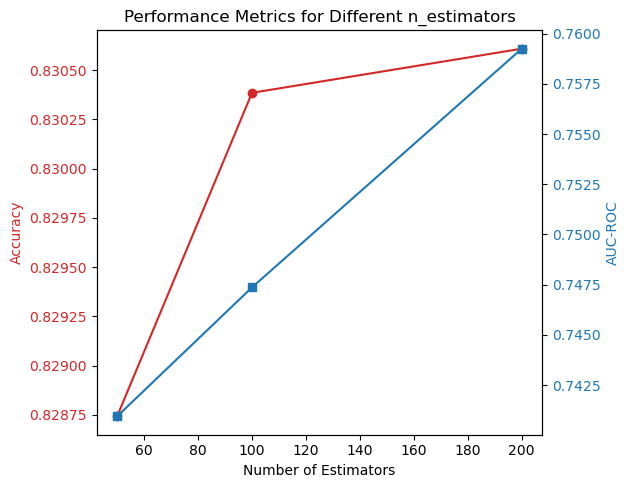

In [95]:
# Visualizing the results
estimators, accuracies, auc_rocs = zip(*results)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Estimators')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(estimators, accuracies, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('AUC-ROC', color=color)  
ax2.plot(estimators, auc_rocs, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Performance Metrics for Different n_estimators')
plt.show()

In [110]:
# Select the best model based on AUC-ROC
best_n_estimators = 100

# Perform 5-fold cross-validation on the best model
best_rf = RandomForestClassifier(n_estimators=best_n_estimators, random_state=37)

# Apply stratified kfold because our target feature is imbalanced
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)

# Perform 5-fold cross-validation
scores = cross_val_score(best_rf, X, y, cv=stratified_kfold, scoring='accuracy')
print(f"Cross-validated scores: {scores}")

Cross-validated scores: [0.82709966 0.82635312 0.82522025 0.82536957 0.82611617]


In [111]:
print(scores.mean())

0.8260317537288205


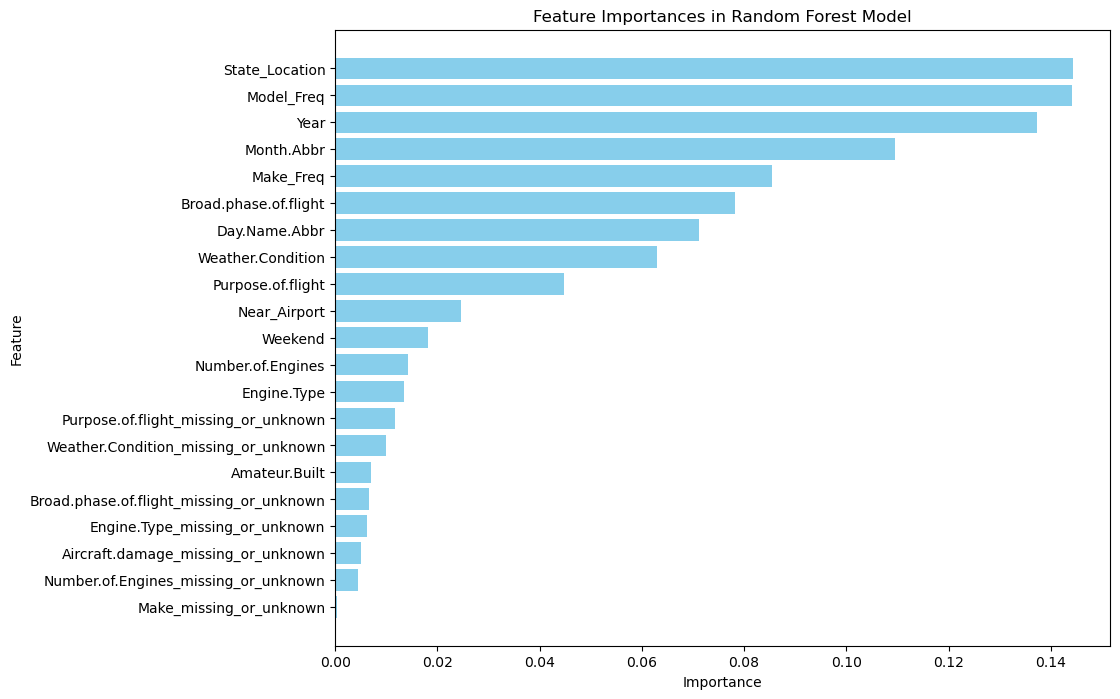

In [112]:
# Train the Random Forest Classifier with n_estimators=100 for feature importance analysis
rf_best = RandomForestClassifier(n_estimators=100, random_state=37)
rf_best.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_best.feature_importances_

# Creating a DataFrame to hold feature names and their importance
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [102]:
# Define the parameter grid
param_grid = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100, random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',  # Using accuracy for simplicity, could also use ROC AUC
                           cv=3,  # Using 3-fold cross-validation
                           verbose=2,
                           n_jobs=-1)  # Use all available cores

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 3 folds for each of 54 candidates, totalling 162 fits


({'max_depth': 30,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 10},
 0.827425947701439)

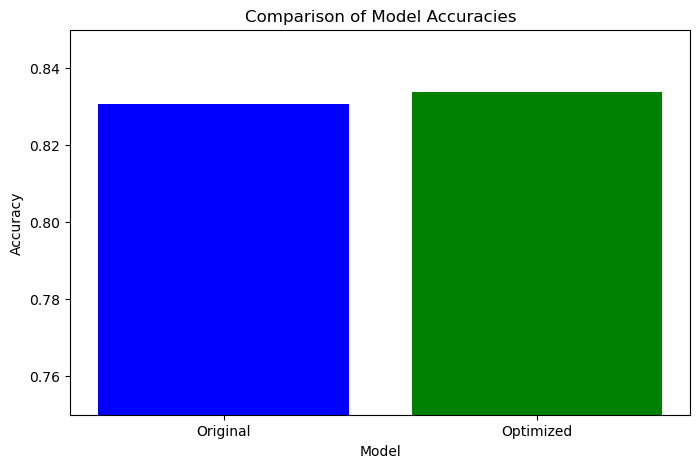

(0.8307577454273983, 0.8338185890257559)

In [104]:
# Set the optimized parameters from the user's grid search result
optimized_params = {
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10
}

# Initialize and train the Random Forest model with the optimized parameters
rf_optimized = RandomForestClassifier(n_estimators=100, random_state=37, **optimized_params)
rf_optimized.fit(X_train, y_train)

# Predict and calculate accuracy for the optimized model
y_pred_optimized = rf_optimized.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

# Initialize and train the original Random Forest model with default parameters
rf_original = RandomForestClassifier(n_estimators=100, random_state=37)
rf_original.fit(X_train, y_train)

# Predict and calculate accuracy for the original model
y_pred_original = rf_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

# Comparing and visualizing the results
accuracies = [accuracy_original, accuracy_optimized]
models = ['Original', 'Optimized']

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0.75, 0.85])  # Set y-axis limits to better highlight differences
plt.show()

accuracy_original, accuracy_optimized

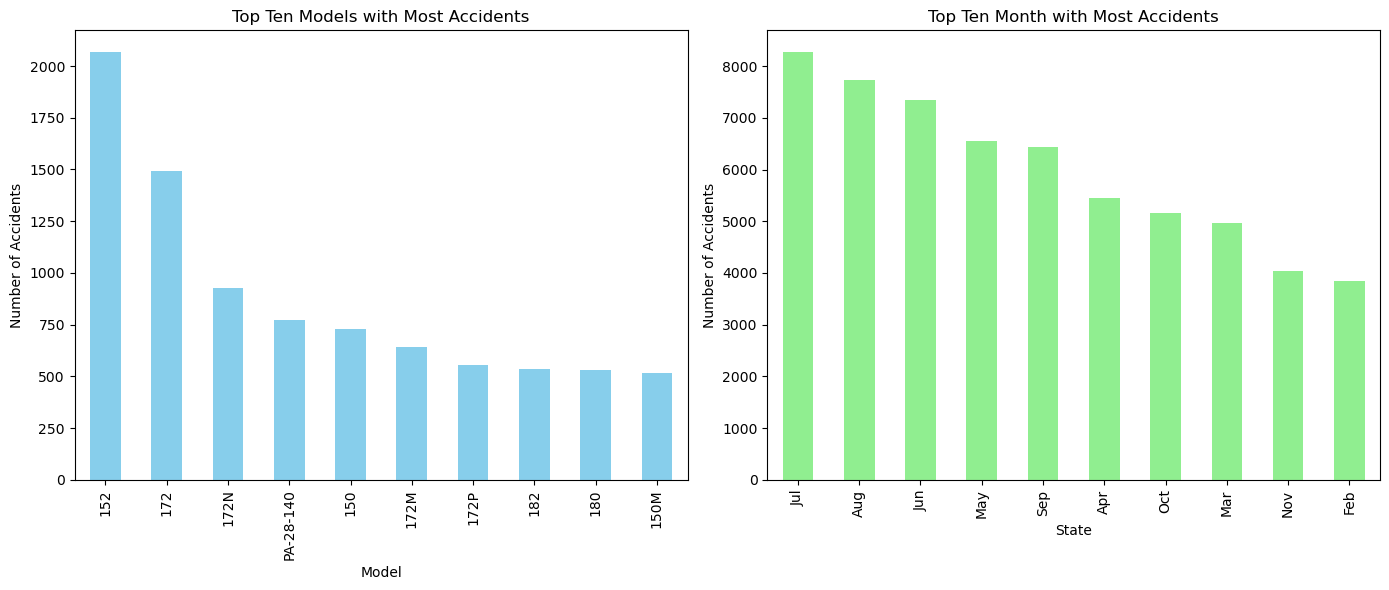

In [116]:
# Top ten models with the most number of accidents
top_models = df_p['Model'].value_counts().head(10)
top_month = df_p['Month.Abbr'].value_counts().head(10)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Top Ten Models Plot
top_models.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top Ten Models with Most Accidents')
axes[0].set_ylabel('Number of Accidents')
axes[0].set_xlabel('Model')

# Top Ten Month Plot
top_month.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Top Ten Month with Most Accidents')
axes[1].set_ylabel('Number of Accidents')
axes[1].set_xlabel('State')

plt.tight_layout()
plt.show()